<a href="https://colab.research.google.com/github/aminbuet/Time-Series-Analysis/blob/master/Weather_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a time serie forecasting using Recurring Neural Networks(RNNs). We do it in two ways: first, Forecast a univariate time series. Then, forecast a multivariate time series.

In [0]:
# impoertant imports
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

__The weather dataset__
This weather dataset recorded by the Max Planck Institute for Biogeochemistry.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, we will use only the data collected between 2009 and 2016.

In [0]:
# File  download and extract
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13574144/13568290 [==============================] - 0s 0us/step


In [0]:
# Read Data
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


As we can see above, an observation is recorded every 10 mintues. This means that, for a single hour, we have 6 observations. Similarly, a single day will contain 144 (6x24) observations.

Given a specific time, let's say we want to predict the temperature 6 hours in the future. In order to make this prediction, we choose to use 5 days of observations. Thus, we would create a window containing the last 720(5x144) observations to train the model. Many such configurations are possible, making this dataset a good one to experiment with.

The function below returns the above described windows of time for the model to train on. 
* The parameter __history_size__ is the size of the past window of information. 
* The __target_size__ is how far in the future does the model need to learn to predict. The __target_size__ is the label that needs to be predicted.

In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
      end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
      indices = range(i - history_size, i) 
      # Reshape data from (history_size,) to (history_size, 1)
      data.append(np.reshape(dataset[indices], (history_size, 1)))
      labels.append(dataset[i + target_size])
    
    return np.array(data), np.array(labels)

Split Dataset --
* Training set (first 300000 rows)
* Validation set ( remaining rows)

This amounts to ~2100 days worth of training data.

In [0]:
TRAIN_SPLIT = 300000

# Setting seed to ensure reproducibility
tf.random.set_seed(13)

__Part 1: Forecast a univariate time series__

First, we will train a model using only a single feature (temperature), and use it to make predictions for that value in the future.

Let's first extract only the temperature from the dataset.

In [0]:
# check column name
df.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

In [0]:
# Extract temperature dataset
uni_data = df['T (degC)']
uni_data.index = df['Date Time']

uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff020cdd400>],
      dtype=object)

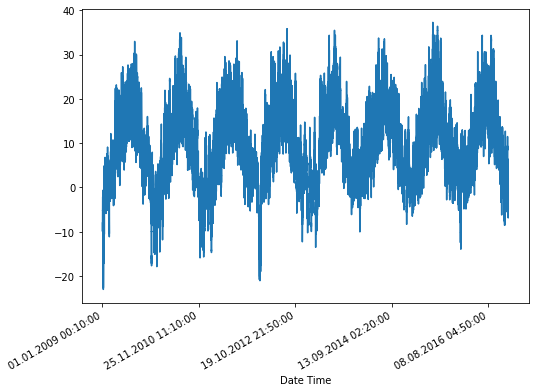

In [0]:
# Visualize a plot
uni_data.plot(subplots=True)

It is important to scale features before training a neural network. Standardization is a common way of doing this scaling by subtracting the mean and dividing by the standard deviation of each feature.

In [0]:
#uni_data = uni_data.values

uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

# Standardize
uni_data = (uni_data - uni_train_mean)/uni_train_std


Let's now create the data for the univariate model. For part 1, the model will be given the last 20 recorded temperature observations, and needs to learn to predict the temperature at the next time step.

In [0]:
uni_past_history = 20
uni_future_target = 0

#Training data
x_train_uni, y_train_uni = univariate_data(uni_data, 0,TRAIN_SPLIT, uni_past_history, uni_future_target)

# Validation Data
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None, uni_past_history, uni_future_target)

In [0]:
#Check
print ('Single window of past history')
print (x_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]


In [0]:
print ('Target temperature to predict')
print (y_train_uni[0])

Target temperature to predict
-2.104184859810088


Now that the data has been created, let's take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross.

In [0]:
def create_time_steps(length):
  return list(range(-length, 0))

In [0]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

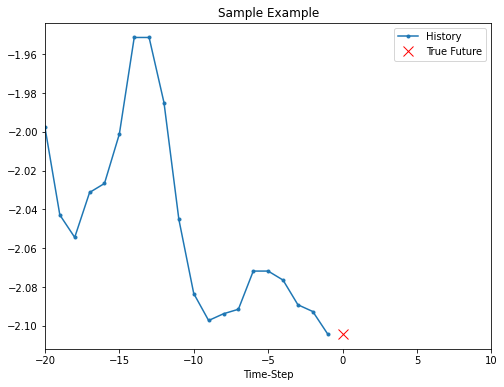

In [0]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

__Baseline__

Before proceeding to train a model, let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 20 observations.

In [0]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

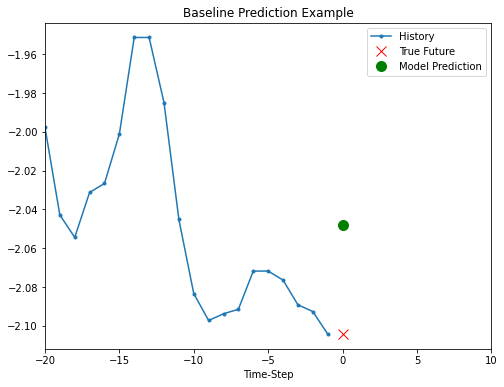

In [0]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

Let's see if we can beat this baseline using a recurrent neural network.



__Recurrent neural network__

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. 

RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. 

We will use a specialized RNN layer called Long Short Term Memory (LSTM)

In [0]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [0]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [0]:
# Let's make a sample prediction, to check the output of the model.

for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


Let's train the model now. Due to the large size of the dataset, in the interest of saving time, each epoch will only run for 200 steps, instead of the complete training data as normally done.



In [0]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 2s 11ms/step - loss: 0.4075 - val_loss: 0.1351
Epoch 2/10
200/200 [==============================] - 2s 9ms/step - loss: 0.1118 - val_loss: 0.0359
Epoch 3/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0489 - val_loss: 0.0290
Epoch 4/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0443 - val_loss: 0.0258
Epoch 5/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0299 - val_loss: 0.0235
Epoch 6/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0317 - val_loss: 0.0224
Epoch 7/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0286 - val_loss: 0.0207
Epoch 8/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0263 - val_loss: 0.0197
Epoch 9/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0253 - val_loss: 0.0181
Epoch 10/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0227 - val_loss: 0.0

__Predict using the simple LSTM model__

Now that you have trained your simple LSTM, let's try and make a few predictions

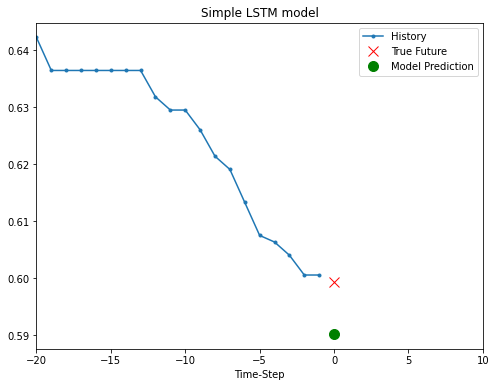

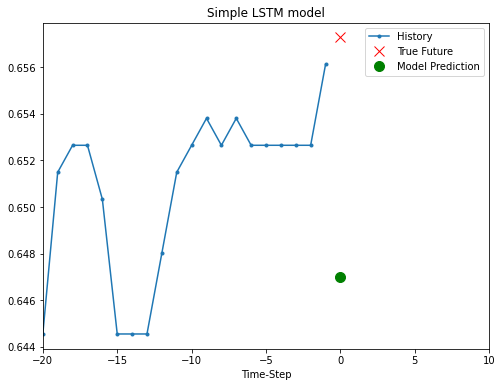

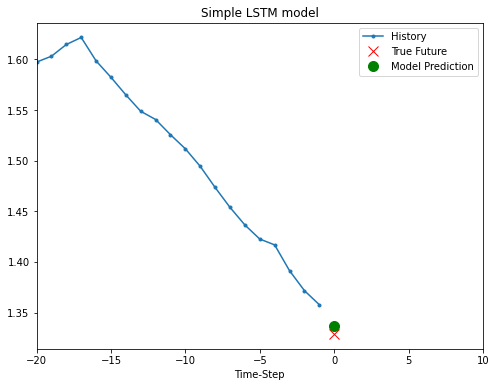

In [0]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

This looks better than the baseline. 

__Part 2: Forecast a multivariate time series__

The original dataset contains fourteen features. For simplicity, this section considers only three of the original fourteen. The features used are air temperature, atmospheric pressure, and air density.

In [0]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff020787d30>,
      dtype=object)

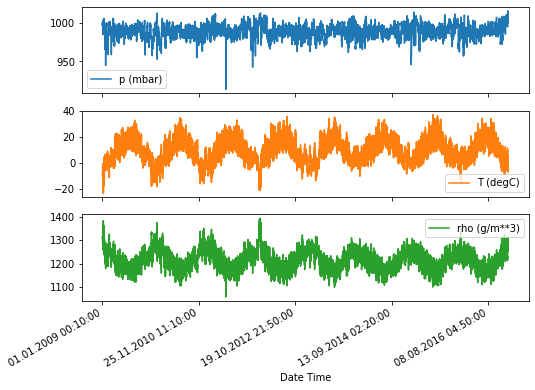

In [0]:
features.plot(subplots=True)


In [0]:
# Standarize Data
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset-data_mean)/data_std

__Single step model__

In a single step setup, the model learns to predict a single point in the future based on some history provided.

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

The network is shown data from the last five (5) days, i.e. 720 observations that are sampled every hour. 

The sampling is done every one hour since a drastic change is not expected within 60 minutes. Thus, 120 observation represent history of the last five days.

For the single step prediction model, the label for a datapoint is the temperature 12 hours into the future. 

In order to create a label for this, the temperature after 72(12*6) observations is used.

In [0]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [0]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [0]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [0]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [0]:
# Check sample prediction
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [0]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 20s 101ms/step - loss: 0.3090 - val_loss: 0.2647
Epoch 2/10
200/200 [==============================] - 20s 100ms/step - loss: 0.2623 - val_loss: 0.2421
Epoch 3/10
200/200 [==============================] - 20s 99ms/step - loss: 0.2611 - val_loss: 0.2448
Epoch 4/10
200/200 [==============================] - 21s 104ms/step - loss: 0.2568 - val_loss: 0.2447
Epoch 5/10
200/200 [==============================] - 21s 103ms/step - loss: 0.2260 - val_loss: 0.2368
Epoch 6/10
200/200 [==============================] - 20s 102ms/step - loss: 0.2412 - val_loss: 0.2658
Epoch 7/10
200/200 [==============================] - 21s 105ms/step - loss: 0.2413 - val_loss: 0.2565
Epoch 8/10
200/200 [==============================] - 21s 105ms/step - loss: 0.2406 - val_loss: 0.2381
Epoch 9/10
200/200 [==============================] - 21s 106ms/step - loss: 0.2451 - val_loss: 0.2480
Epoch 10/10
200/200 [==============================] - 21s 104ms/step - lo

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

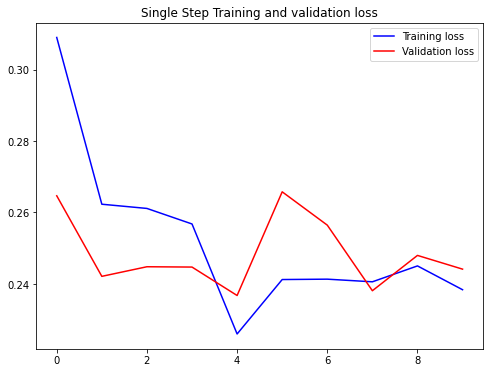

In [0]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

__Predict a single step future__

Now that the model is trained, let's make a few sample predictions. 

The model is given the history of three features over the past five days sampled every hour (120 data-points), since the goal is to predict the temperature, the plot only displays the past **temperature**.

The prediction is made one day into the future (hence the gap between the history and prediction).

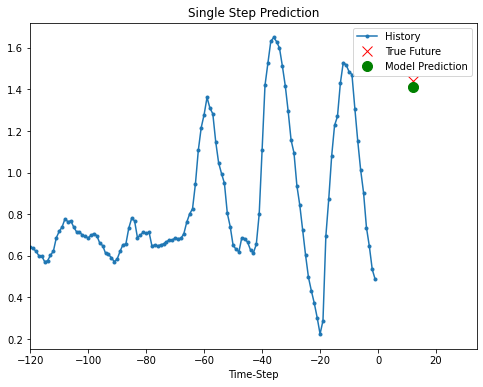

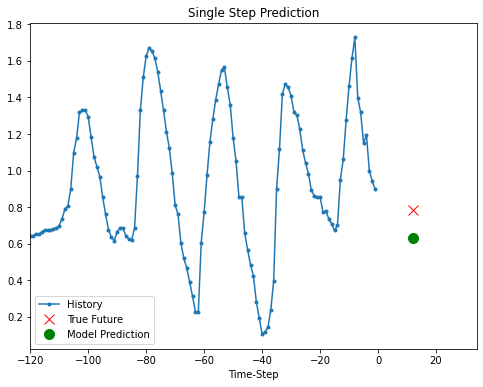

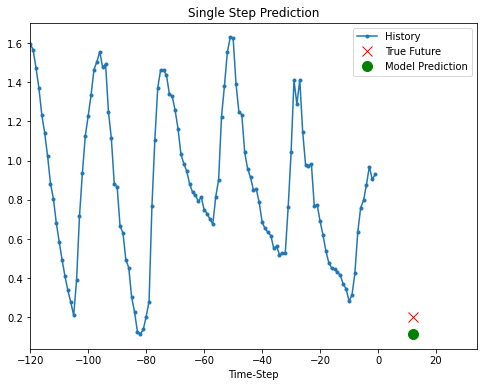

In [0]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

**Multi-Step model**

In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a **multi-step model predict a sequence of the future.**

For the multi-step model, the training data again consists of recordings over the past five days sampled every hour. However, here, the model needs to learn to predict the temperature for the next 12 hours.

Since an obversation is taken every 10 minutes, the output is 72 predictions. For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.

In [0]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [0]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [0]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [0]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

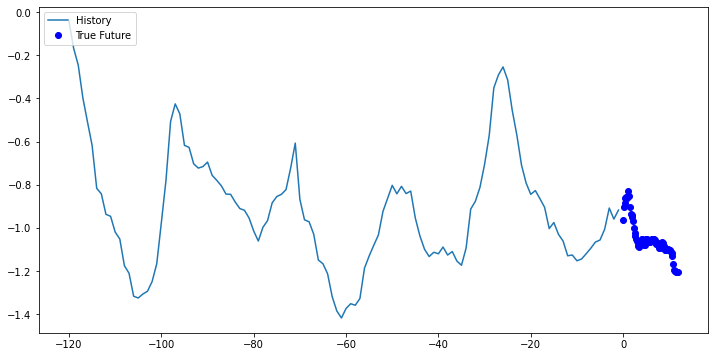

In [0]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers. Finally, since 72 predictions are made, the dense layer outputs 72 predictions.



In [0]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [0]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(256, 72)


In [0]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 34s 172ms/step - loss: 0.4949 - val_loss: 0.3073
Epoch 2/10
200/200 [==============================] - 34s 170ms/step - loss: 0.3465 - val_loss: 0.2871
Epoch 3/10
200/200 [==============================] - 36s 182ms/step - loss: 0.3290 - val_loss: 0.2466
Epoch 4/10
200/200 [==============================] - 36s 181ms/step - loss: 0.2431 - val_loss: 0.2092
Epoch 5/10
200/200 [==============================] - 36s 179ms/step - loss: 0.1977 - val_loss: 0.1996
Epoch 6/10
200/200 [==============================] - 36s 178ms/step - loss: 0.2077 - val_loss: 0.2083
Epoch 7/10
200/200 [==============================] - 37s 187ms/step - loss: 0.1990 - val_loss: 0.2074
Epoch 8/10
200/200 [==============================] - 38s 190ms/step - loss: 0.1956 - val_loss: 0.1965
Epoch 9/10
200/200 [==============================] - 38s 189ms/step - loss: 0.1976 - val_loss: 0.1914
Epoch 10/10
200/200 [==============================] - 38s 188ms/step - l

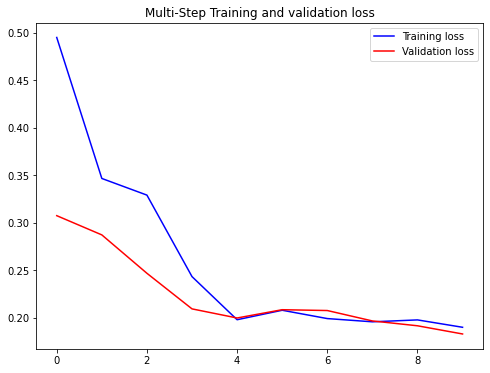

In [0]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

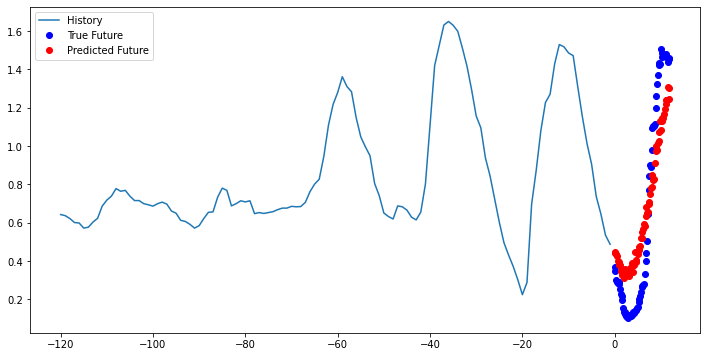

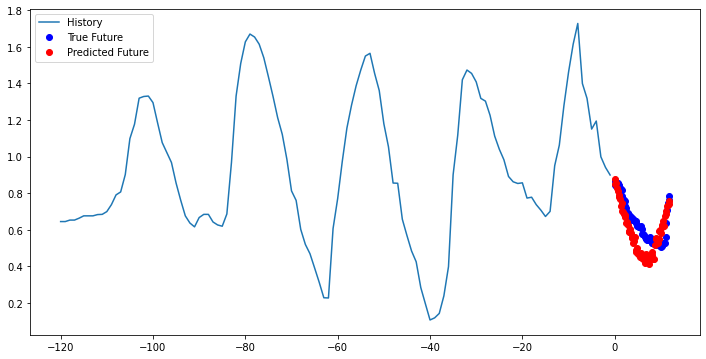

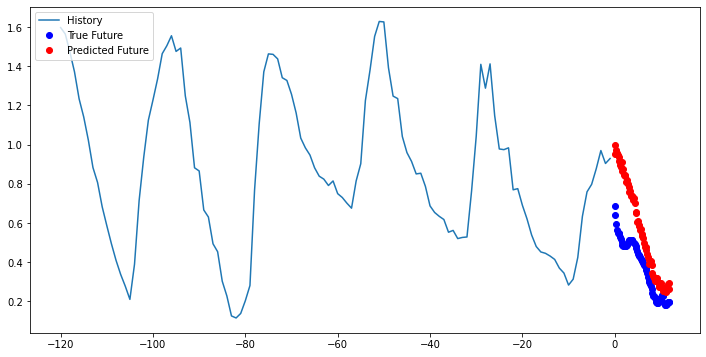

In [0]:
#prediction
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])